# Исследования TensorFlow на данных CIFAR-10

1. Дефолтная модель.

2. Добавление L2 - регуляризации.

3. Добавление аугментации.

4. Нормализация по мини-батчам.

5. Результаты и выводы.

# CIFAR-10 с трюками

В этом задании продолжим работать с CIFAR-10, опробовав трюки, про которые вы узнали в модуле.

Датасет CIFAR-10 состоит из цветных картинок 32 × 32, разделённых на 10 классов:

__airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck__.

# Импорты

In [1]:
#pip install tensorflow==2.1

In [1]:
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.models as M
import tensorflow.keras.layers as L
import tensorflow.keras.backend as K
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
print(tf.__version__)
print(keras.__version__)
from tensorflow.keras.datasets import cifar10
# слои
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras import models, regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

2025-01-08 17:25:05.492936: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


2.11.0
2.11.0


# Загружаем данные

In [2]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [4]:
print("Трейн:", x_train.shape, y_train.shape)
print("Тест:", x_test.shape, y_test.shape)

Трейн: (50000, 32, 32, 3) (50000, 1)
Тест: (10000, 32, 32, 3) (10000, 1)


In [5]:
NUM_CLASSES = 10
cifar10_classes = ["airplane", "automobile", "bird", "cat", "deer",
                   "dog", "frog", "horse", "ship", "truck"]

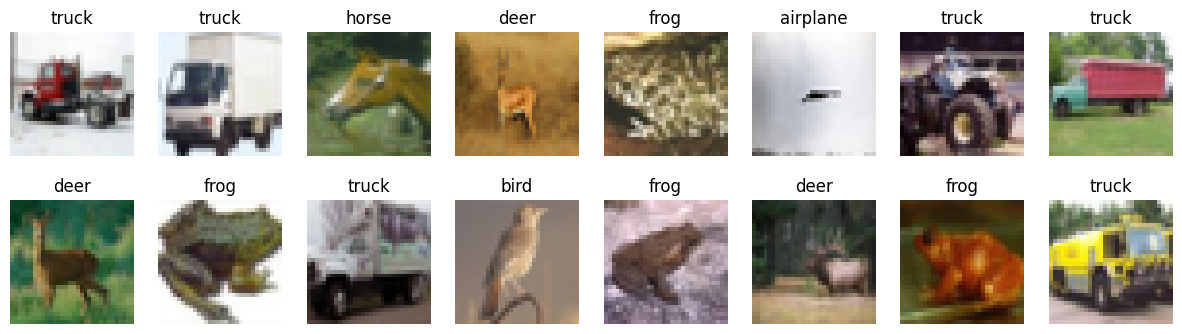

In [6]:
# посмотрим на примеры картинок
cols = 8
rows = 2
fig = plt.figure(figsize=(2 * cols - 1, 2.5 * rows - 1))
for i in range(cols):
    for j in range(rows):
        random_index = np.random.randint(0, len(y_train))
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid('off')
        ax.axis('off')
        ax.imshow(x_train[random_index, :])
        ax.set_title(cifar10_classes[y_train[random_index, 0]])
plt.show()

# Готовим данные

Не забудьте нормализовать картинки: $$x_{norm} = \frac{x}{255} - 0.5$$

А ещё нужно превратить метки в one-hot-векторы при помощи __keras.utils.to_categorical__.

In [7]:
# нормализуем входы
x_train2 = x_train.astype('float32') / 255 - 0.5
x_test2 = x_test.astype('float32') / 255 - 0.5

# конвертируем метки в np.array (?, NUM_CLASSES)
y_train2 = keras.utils.to_categorical(y_train, NUM_CLASSES)
y_test2 = keras.utils.to_categorical(y_test, NUM_CLASSES)

# Задаём *дефолтную* архитектуру сети

Нам понадобятся такие слои:
- [Conv2D](https://keras.io/layers/convolutional/#conv2d) — свёрточный слой:
    - **filters**: количество фильтров на выходе;
    - **kernel_size**: размер скользящего окна;
    - **padding**: padding="same" добивает нулями, чтобы ширина и высота на выходе не изменились, padding='valid' берёт только окна, которые полностью помещаются в картинке;
    - **activation**: "relu", "tanh" и так далее;
    - **input_shape**: размер входа вида (W, H, C_in).
- [MaxPooling2D](https://keras.io/layers/pooling/#maxpooling2d) — пулинг.
- [Flatten](https://keras.io/layers/core/#flatten) — все оси, кроме батча (первая ось), вытягиваются в один вектор.
- [Dense](https://keras.io/layers/core/#dense) — плотный, активацию можно задать через activation="elu" или activation="softmax".
- [Dropout](https://keras.io/layers/core/#dropout) — дропаут-регуляризация (без неё сеть сильно переобучается). Позже узнаем, какой у неё смысл.

Ваша модель должна принимать на вход цветную картинку __(None, 32, 32, 3)__ и предсказывать вероятности 10 классов __(None, 10)__.

Добавьте __4__ свёрточных слоя с окном __(3, 3)__ с нарастающим количеством фильтров: __(16, 32, 32, 64)__, используйте паддинг "same".

Добавьте __2 × 2__ максимальный пулинг после каждых двух свёрточных слоёв (схема conv-conv-pool).

Используйте __activation='relu'__ для всех слоёв, где это нужно.

Добавьте плотный слой из __256__ нейронов и ещё один из __10__ нейронов для предсказания выходов. Не забудьте применить __Flatten__ перед первым плотным слоем!

Для регуляризации сети вставьте Dropout после каждого пулинг-слоя (с параметром** 0.25**) и между плотными слоями на выходе (с параметром **0.5**).

В дальнейшем будем называть эту архитектуру **дефолтной** и исследовать небольшие изменения в ней.

In [8]:
def make_default_model():
    model = Sequential()
    model.add(L.Conv2D(filters=16, kernel_size=3, activation='relu', padding='same', input_shape=(32, 32, 3)))
    model.add(L.Conv2D(filters=32, kernel_size=3, activation='relu', padding='same'))
    model.add(L.MaxPooling2D((2, 2)))
    model.add(L.Dropout(0.25))  # регуляризация сети
    model.add(L.Conv2D(filters=32, kernel_size=3, activation='relu', padding='same'))
    model.add(L.Conv2D(filters=64, kernel_size=3, activation='relu', padding='same'))
    model.add(L.MaxPooling2D((2, 2)))
    model.add(L.Dropout(0.25))  # регуляризация сети
    model.add(L.Flatten())  # Преобразование в вектор
    model.add(L.Dense(256, activation='relu'))  # Полносвязный слой
    model.add(L.Dropout(0.5)) # регуляризация сети
    model.add(L.Dense(10, activation='softmax'))  # Выходной слой для классификации на 10 классов

    return model

In [9]:
K.clear_session()
model = make_default_model()
model.summary()

2024-12-26 17:13:02.332368: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 16)        448       
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        4640      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 16, 16, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 32)        9248      
                                                                 
 conv2d_3 (Conv2D)           (None, 16, 16, 64)        18496     
                                                        

# Тренируем модель

In [10]:
def train_model(make_model_func, optimizer="adam"):
  BATCH_SIZE = 32
  EPOCHS = 10

  K.clear_session()
  model = make_model_func()

  model.compile(
      loss='categorical_crossentropy',
      optimizer=optimizer,
      metrics=['accuracy']
  )

  history = model.fit(
      x_train2, y_train2,  # нормализованные данные
      batch_size=BATCH_SIZE,
      epochs=EPOCHS,
      validation_data=(x_test2, y_test2),
      shuffle=False
  )

  return model, history


In [11]:
model, history = train_model(make_default_model)

Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
1563/1563 [==============================] - ETA: 0s - loss: 1.4733 - accuracy: 0.4648WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7cb581381200> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) 

Просмотр результатов дефолтной модели.

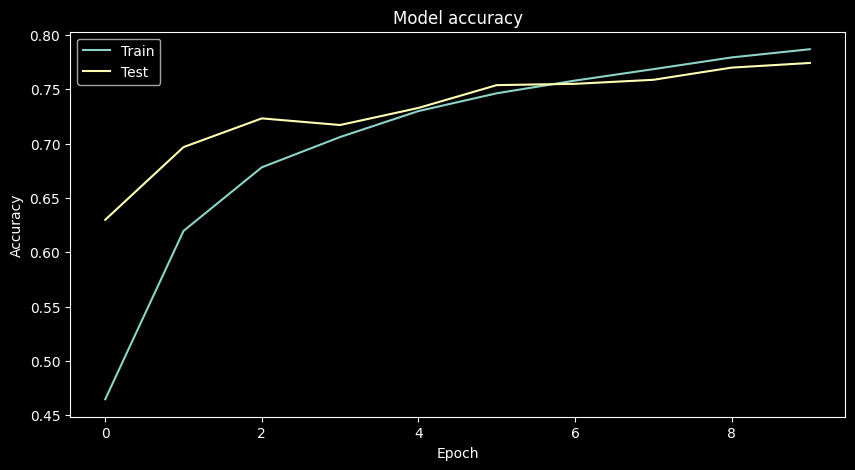

In [12]:
# Plot training & validation accuracy values
plt.style.use(['dark_background'])
fig, ax = plt.subplots(figsize=(10, 5))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

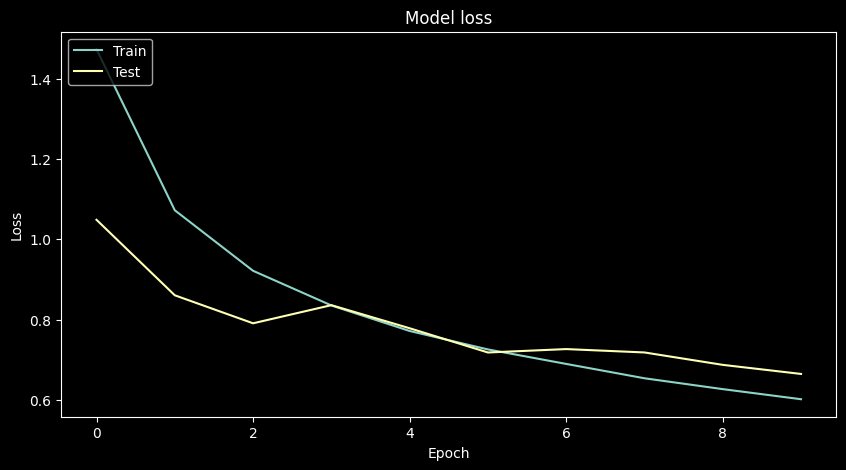

In [13]:
# Plot training & validation loss values
plt.style.use(['dark_background'])
fig, ax = plt.subplots(figsize=(10, 5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [14]:
# Вывод истории обучения 
print('=====', 'defolt model accuracy:', '=====')
print(history.history['accuracy'])
print(history.history['val_accuracy'])
print('=====', 'defolt model loss:', '=====')
print(history.history['loss'])
print(history.history['val_loss'])

===== defolt model accuracy: =====
[0.46480000019073486, 0.6196799874305725, 0.6782000064849854, 0.7060400247573853, 0.7299200296401978, 0.7462800145149231, 0.7579799890518188, 0.7684800028800964, 0.7792800068855286, 0.78684002161026]
[0.6298999786376953, 0.6967999935150146, 0.7232000231742859, 0.7171000242233276, 0.7328000068664551, 0.7537999749183655, 0.7549999952316284, 0.7587000131607056, 0.7699000239372253, 0.7742000222206116]
===== defolt model loss: =====
[1.4732887744903564, 1.0723850727081299, 0.9216828942298889, 0.8354436159133911, 0.7718756198883057, 0.7259050011634827, 0.6898470520973206, 0.654125988483429, 0.6271124482154846, 0.6019794940948486]
[1.0486303567886353, 0.8607180714607239, 0.7909854054450989, 0.8361409306526184, 0.7786623239517212, 0.7183265089988708, 0.726794958114624, 0.718397855758667, 0.6875150799751282, 0.6649067401885986]


## Добавление в модель L2-регуляризации


    Предотвращение переобучения: L2-регуляризация помогает уменьшить переобучение модели, добавляя штраф за большие веса.

    Сглаживание функции потерь: Это делает модель менее чувствительной к шуму в данных.
    
    Улучшение обобщающей способности: Модели с регуляризацией обычно лучше обобщают на новых данных.


Добавление L2-регуляризации для сверточных слоев и полносвязных слоев.

In [15]:
def make_reglarized_model():
    model = Sequential()
    model.add(L.Conv2D(filters=16, kernel_size=3, activation='relu', padding='same',
                       kernel_regularizer=regularizers.l2(0.001), input_shape=(32, 32, 3)))
    model.add(L.Conv2D(filters=32, kernel_size=3, activation='relu', padding='same',
                       kernel_regularizer=regularizers.l2(0.001)))
    model.add(L.MaxPooling2D((2, 2)))
    model.add(L.Dropout(0.25))  # Регуляризация сети
    model.add(L.Conv2D(filters=32, kernel_size=3, activation='relu', padding='same',
                       kernel_regularizer=regularizers.l2(0.001)))
    model.add(L.Conv2D(filters=64, kernel_size=3, activation='relu', padding='same',
                       kernel_regularizer=regularizers.l2(0.001)))
    model.add(L.MaxPooling2D((2, 2)))
    model.add(L.Dropout(0.25))  # Регуляризация сети
    model.add(L.Flatten())  # Преобразование в вектор
    model.add(L.Dense(256, activation='relu',
                      kernel_regularizer=regularizers.l2(0.001)))  # Полносвязный слой с регуляризацией
    model.add(L.Dropout(0.5))  # Регуляризация сети
    model.add(L.Dense(10, activation='softmax'))  # Выходной слой для классификации на 10 классов

    return model

In [16]:
model_l2, history_l2 = train_model(make_reglarized_model)

Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
1563/1563 [==============================] - ETA: 0s - loss: 1.7381 - accuracy: 0.4436WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7cb5802c7e60> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) 

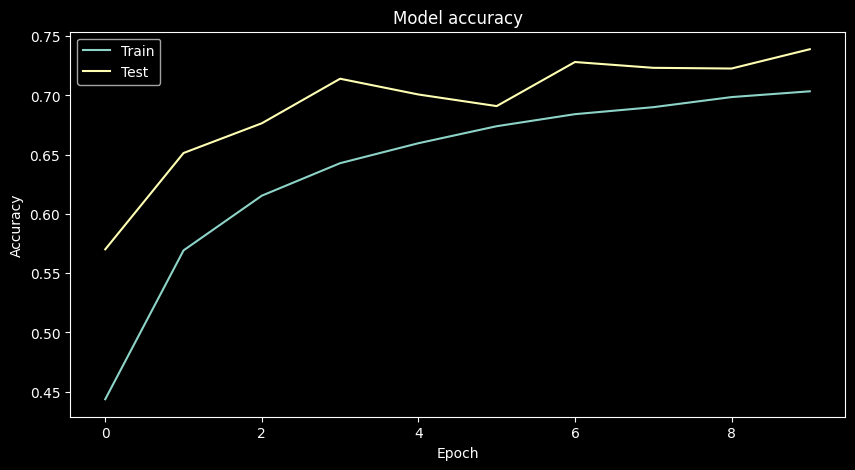

In [17]:
# Plot training & validation accuracy values
plt.style.use(['dark_background'])
fig, ax = plt.subplots(figsize=(10, 5))
plt.plot(history_l2.history['accuracy'])
plt.plot(history_l2.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

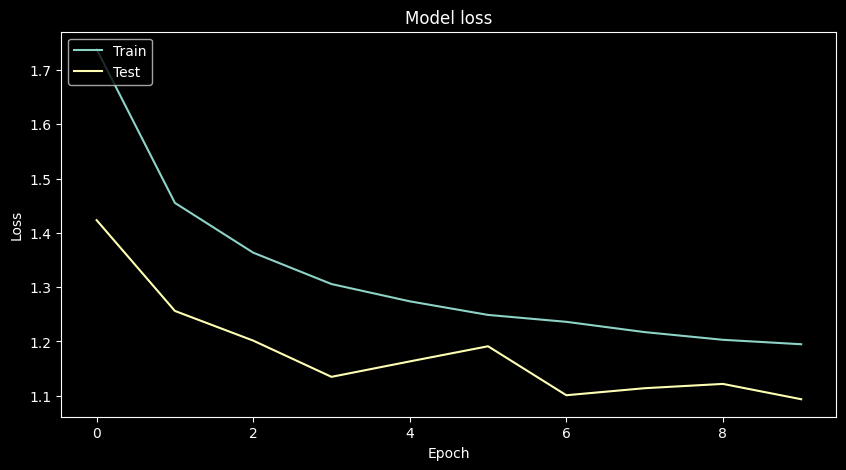

In [18]:
# Plot training & validation loss values
plt.style.use(['dark_background'])
fig, ax = plt.subplots(figsize=(10, 5))
plt.plot(history_l2.history['loss'])
plt.plot(history_l2.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [19]:
# Вывод истории обучения 
print('=====', 'l2 model accuracy:', '=====')
print(history_l2.history['accuracy'])
print(history_l2.history['val_accuracy'])
print('=====', 'l2 model loss:', '=====')
print(history_l2.history['loss'])
print(history_l2.history['val_loss'])

===== l2 model accuracy: =====
[0.44359999895095825, 0.5692200064659119, 0.6154000163078308, 0.6428200006484985, 0.6596599817276001, 0.674019992351532, 0.6841800212860107, 0.6900799870491028, 0.6985999941825867, 0.7034800052642822]
[0.5701000094413757, 0.6514000296592712, 0.6765000224113464, 0.7141000032424927, 0.7008000016212463, 0.6909999847412109, 0.7282000184059143, 0.7232999801635742, 0.7226999998092651, 0.7390000224113464]
===== l2 model loss: =====
[1.7381136417388916, 1.4551193714141846, 1.3635004758834839, 1.3057215213775635, 1.2738982439041138, 1.248865008354187, 1.2361291646957397, 1.2172220945358276, 1.2030534744262695, 1.1948720216751099]
[1.4233499765396118, 1.2561962604522705, 1.2015634775161743, 1.1348271369934082, 1.163238525390625, 1.1911519765853882, 1.100967526435852, 1.1139088869094849, 1.1218277215957642, 1.0936250686645508]


требуется очень серьезная настройка

# Добавление аугментации

Аугментация данных — это техника, используемая для увеличения объема обучающего набора путем применения различных трансформаций к исходным изображениям. Это может помочь улучшить обобщающую способность модели, так как она будет обучаться на более разнообразных данных.

Аугментацию можно добавлять на этапе подготовки данных перед обучением модели. В TensorFlow есть несколько способов сделать это, но одним из самых удобных является использование ImageDataGenerator из Keras или создания пользовательских классов и функций.


Использование ImageDataGenerator

ImageDataGenerator позволяет применять ряд трансформаций, таких как сдвиг, поворот, масштабирование, отражение и др., "на лету". Это означает, что данные преобразуются в реальном времени во время обучения, а не сохраняются в виде новых изображений на диске.

Использование tf.keras.layers

В TensorFlow также доступна возможность аугментации данных с использованием слоев Keras, таких как tf.keras.layers.RandomFlip, tf.keras.layers.RandomRotation, и т.д. Это позволяет включать аугментацию непосредственно в модель.

Использование L2-регуляризации и аугментации данных одновременно в модели для CIFAR-10 имеет смысл и может привести к улучшению обобщающей способности модели. Однако важно тщательно настраивать гиперпараметры и следить за метриками производительности во время обучения, чтобы обеспечить оптимальный баланс между регуляризацией и обучением на разнообразных данных.

In [20]:
def make_augment_model():
    model = models.Sequential()
    
    # Слои аугментации
    model.add(L.Input(shape=(32, 32, 3)))  # Входной слой
    model.add(tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"))  # Случайное отражение
    model.add(tf.keras.layers.experimental.preprocessing.RandomRotation(0.2))  # Случайный поворот до 20%
    model.add(tf.keras.layers.experimental.preprocessing.RandomZoom(0.2))  # Случайное масштабирование
    
    # Свёрточные слои с регуляризацией
    model.add(L.Conv2D(filters=16, kernel_size=3, activation='relu', padding='same'))
    model.add(L.Conv2D(filters=32, kernel_size=3, activation='relu', padding='same'))
    model.add(L.MaxPooling2D((2, 2)))
    model.add(L.Dropout(0.25))  # Регуляризация сети

    model.add(L.Conv2D(filters=32, kernel_size=3, activation='relu', padding='same'))
    model.add(L.Conv2D(filters=64, kernel_size=3, activation='relu', padding='same'))
    model.add(L.MaxPooling2D((2, 2)))
    model.add(L.Dropout(0.25))  # Регуляризация сети

    model.add(L.Flatten())  # Преобразование в вектор
    model.add(L.Dense(256, activation='relu'))  # Полносвязный слой без регуляризации
    model.add(L.Dropout(0.5))  # Регуляризация сети
    model.add(L.Dense(10, activation='softmax'))  # Выходной слой для классификации на 10 классов

    return model

В версии TensorFlow 2.1.0 не поддерживается использование слоев аугментации, таких как RandomFlip, RandomRotation и RandomZoom, в виде слоев в модели Sequential. Вместо этого их следует применять через ImageDataGenerator 

In [21]:
# Применение аугментации данных с помощью ImageDataGenerator
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
)

# Подготовка генератора для обучения
datagen.fit(x_train2)

In [22]:
# воспользуемся архитектурой дефолтной нейросети
# Создание и компиляция модели
model_aug = make_default_model()
model_aug.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [23]:
# Обучение модели с использованием генератора аугментированных данных
history_aug = model_aug.fit(datagen.flow(x_train2, y_train2, batch_size=32),
                    epochs=10,
                    validation_data=(x_test2, y_test2))

Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
1563/1563 [==============================] - ETA: 0s - loss: 1.6032 - accuracy: 0.4121WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7cb5800c4a70> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) 

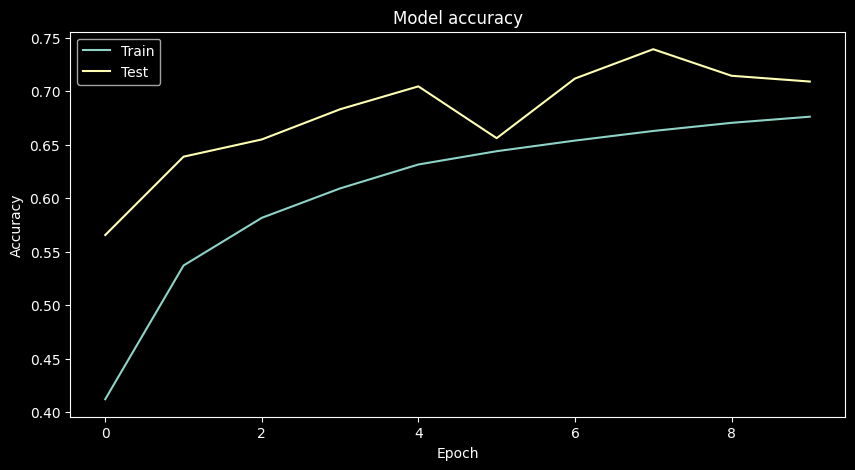

In [24]:
# Plot training & validation accuracy values
plt.style.use(['dark_background'])
fig, ax = plt.subplots(figsize=(10, 5))
plt.plot(history_aug.history['accuracy'])
plt.plot(history_aug.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

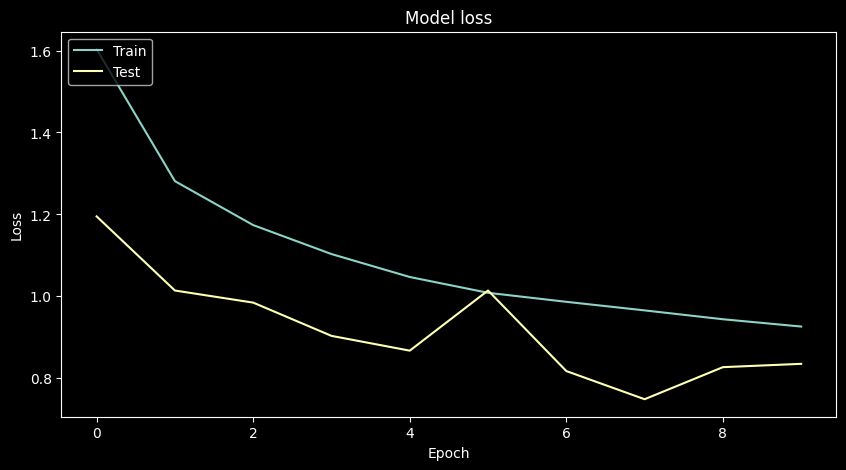

In [25]:
# Plot training & validation loss values
plt.style.use(['dark_background'])
fig, ax = plt.subplots(figsize=(10, 5))
plt.plot(history_aug.history['loss'])
plt.plot(history_aug.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [26]:
# Вывод истории обучения 
print('=====', 'augmentation model accuracy:', '=====')
print(history_aug.history['accuracy'])
print(history_aug.history['val_accuracy'])
print('=====', 'augmentation model loss:', '=====')
print(history_aug.history['loss'])
print(history_aug.history['val_loss'])

===== augmentation model accuracy: =====
[0.4120999872684479, 0.5370399951934814, 0.5815799832344055, 0.6090599894523621, 0.6314200162887573, 0.6438199877738953, 0.6537399888038635, 0.6627200245857239, 0.6703199744224548, 0.6760600209236145]
[0.565500020980835, 0.638700008392334, 0.6547999978065491, 0.6830000281333923, 0.7044000029563904, 0.656000018119812, 0.7117000222206116, 0.7390999794006348, 0.7142999768257141, 0.708899974822998]
===== augmentation model loss: =====
[1.603161096572876, 1.2812167406082153, 1.1739368438720703, 1.1032664775848389, 1.0472904443740845, 1.0087164640426636, 0.9867203831672668, 0.965798020362854, 0.9442028403282166, 0.9263547658920288]
[1.1951885223388672, 1.0142842531204224, 0.9847710728645325, 0.903616189956665, 0.8675587773323059, 1.0143519639968872, 0.8177534937858582, 0.7490099668502808, 0.8272485136985779, 0.8353785872459412]


# Нормализация по мини-батчам.

Метод, который помогает ускорить обучение нейронных сетей и делает его более стабильным. Он нормализует входные данные для каждого слоя, что помогает уменьшить внутреннее смещение. Это позволяет использовать более высокие скорости обучения и уменьшает вероятность переобучения.

    Скорость обучения: Увеличивает скорость сходимости модели.
    Стабильность: Уменьшает чувствительность к инициализации весов.
    Регуляризация: Может действовать как форма регуляризации, что помогает избежать переобучения.


In [27]:
def make_batch_norm_model():
    model = models.Sequential()
    
    # Первый сверточный слой
    model.add(L.Conv2D(filters=16, kernel_size=3, activation='relu', padding='same', input_shape=(32, 32, 3)))
    model.add(L.BatchNormalization())  # Добавление Batch Normalization
    
    # Второй сверточный слой
    model.add(L.Conv2D(filters=32, kernel_size=3, activation='relu', padding='same'))
    model.add(L.BatchNormalization())  # Добавление Batch Normalization
    
    model.add(L.MaxPooling2D((2, 2)))
    model.add(L.Dropout(0.25))  # Регуляризация сети

    # Третий сверточный слой
    model.add(L.Conv2D(filters=32, kernel_size=3, activation='relu', padding='same'))
    model.add(L.BatchNormalization())  # Добавление Batch Normalization
    
    # Четвертый сверточный слой
    model.add(L.Conv2D(filters=64, kernel_size=3, activation='relu', padding='same'))
    model.add(L.BatchNormalization())  # Добавление Batch Normalization
    
    model.add(L.MaxPooling2D((2, 2)))
    model.add(L.Dropout(0.25))  # Регуляризация сети

    model.add(L.Flatten())  # Преобразование в вектор
    model.add(L.Dense(256, activation='relu'))  # Полносвязный слой
    model.add(L.BatchNormalization())  # Добавление Batch Normalization после полносвязного слоя
    model.add(L.Dropout(0.5))  # Регуляризация сети
    
    model.add(L.Dense(10, activation='softmax'))  # Выходной слой для классификации на 10 классов

    return model

In [28]:
model_batch, history_batch = train_model(make_batch_norm_model)

Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
1563/1563 [==============================] - ETA: 0s - loss: 1.4835 - accuracy: 0.4905WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7cb5898f5440> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) 

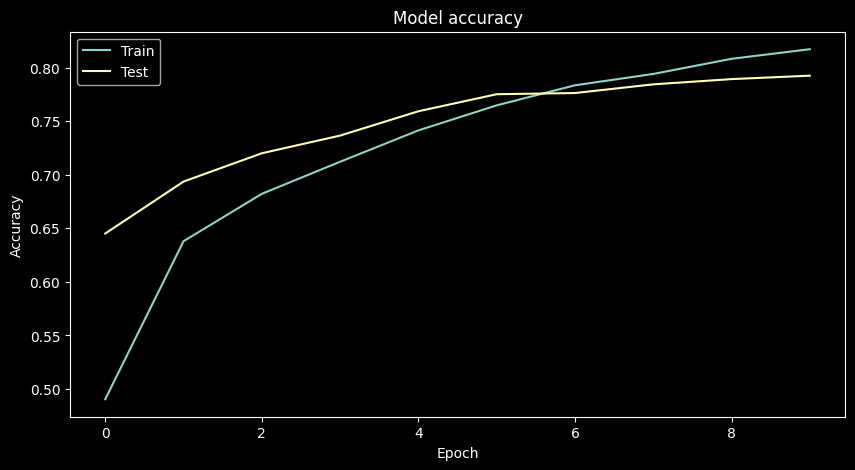

In [29]:
# Plot training & validation accuracy values
plt.style.use(['dark_background'])
fig, ax = plt.subplots(figsize=(10, 5))
plt.plot(history_batch.history['accuracy'])
plt.plot(history_batch.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

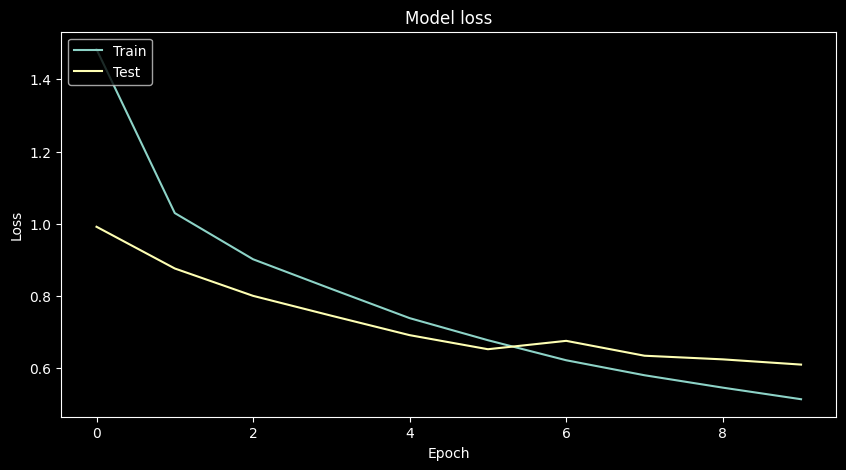

In [30]:
# Plot training & validation loss values
plt.style.use(['dark_background'])
fig, ax = plt.subplots(figsize=(10, 5))
plt.plot(history_batch.history['loss'])
plt.plot(history_batch.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [31]:
# Вывод истории обучения 
print('=====', 'batch_normalize model accuracy:', '=====')
print(history_batch.history['accuracy'])
print(history_batch.history['val_accuracy'])
print('=====', 'batch_normalize model loss:', '=====')
print(history_batch.history['loss'])
print(history_batch.history['val_loss'])

===== batch_normalize model accuracy: =====
[0.49052000045776367, 0.6379600167274475, 0.6821399927139282, 0.7120800018310547, 0.7413399815559387, 0.7646999955177307, 0.7834200263023376, 0.7940000295639038, 0.808139979839325, 0.817080020904541]
[0.6450999975204468, 0.6935999989509583, 0.7200000286102295, 0.7365000247955322, 0.7591999769210815, 0.7750999927520752, 0.776199996471405, 0.7843000292778015, 0.7892000079154968, 0.7924000024795532]
===== batch_normalize model loss: =====
[1.4834609031677246, 1.029551386833191, 0.9015776515007019, 0.8194211721420288, 0.7384814620018005, 0.6773121356964111, 0.621784508228302, 0.5802688002586365, 0.5459288954734802, 0.5138464570045471]
[0.9916340708732605, 0.876015841960907, 0.8002157211303711, 0.7452287077903748, 0.6913320422172546, 0.6523609757423401, 0.6755823493003845, 0.6343644857406616, 0.6242715120315552, 0.6097897887229919]


# Итоговая модель

С дополнительными слоями и BatchNormalization

In [32]:
# Нормализация данных
x_train2 = x_train.astype('float32') / 255.0 - 0.5  # Нормализация в диапазоне [-0.5, 0.5]
x_test2 = x_test.astype('float32') / 255.0 - 0.5

# Преобразование меток в формат One-Hot Encoding
y_train2 = tf.keras.utils.to_categorical(y_train, NUM_CLASSES)
y_test2 = tf.keras.utils.to_categorical(y_test, NUM_CLASSES)

In [33]:
# Определение модели
def make_final_model():
    model = models.Sequential()

    # Слои аугментации (можно использовать отдельно)
    model.add(L.Input(shape=(32, 32, 3)))  # Входной слой
    
    # Первый сверточный слой
    model.add(L.Conv2D(filters=16, kernel_size=3, activation='relu', padding='same', input_shape=(32, 32, 3)))
    model.add(L.BatchNormalization())  # Нормализация
    model.add(L.Conv2D(filters=32, kernel_size=3, activation='relu', padding='same'))
    model.add(L.BatchNormalization())  # Нормализация
    model.add(L.MaxPooling2D((2, 2)))  # Пулинг
    model.add(L.Dropout(0.25))  # Регуляризация

    # Второй сверточный блок
    model.add(L.Conv2D(filters=32, kernel_size=3, activation='relu', padding='same'))
    model.add(L.BatchNormalization())  # Нормализация
    model.add(L.Conv2D(filters=64, kernel_size=3, activation='relu', padding='same'))
    model.add(L.BatchNormalization())  # Нормализация
    model.add(L.MaxPooling2D((2, 2)))  # Пулинг
    model.add(L.Dropout(0.25))  # Регуляризация

    # Третий сверточный блок
    model.add(L.Conv2D(filters=64, kernel_size=3, activation='relu', padding='same'))
    model.add(L.BatchNormalization())  # Нормализация
    model.add(L.Conv2D(filters=128, kernel_size=3, activation='relu', padding='same'))
    model.add(L.BatchNormalization())  # Нормализация
    model.add(L.MaxPooling2D((2, 2)))  # Пулинг
    model.add(L.Dropout(0.25))  # Регуляризация

    # Полносвязные слои
    model.add(L.Flatten())  # Преобразование в вектор
    model.add(L.Dense(256, activation='relu'))  # Полносвязный слой
    model.add(L.BatchNormalization())  # Нормализация после полносвязного слоя
    model.add(L.Dropout(0.5))  # Регуляризация

    # Выходной слой для классификации на 10 классов
    model.add(L.Dense(NUM_CLASSES, activation='softmax'))

    return model

In [34]:
model_final, history_final = train_model(make_final_model)

Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
1563/1563 [==============================] - ETA: 0s - loss: 1.5431 - accuracy: 0.4679WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7cb57efda8c0> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) 

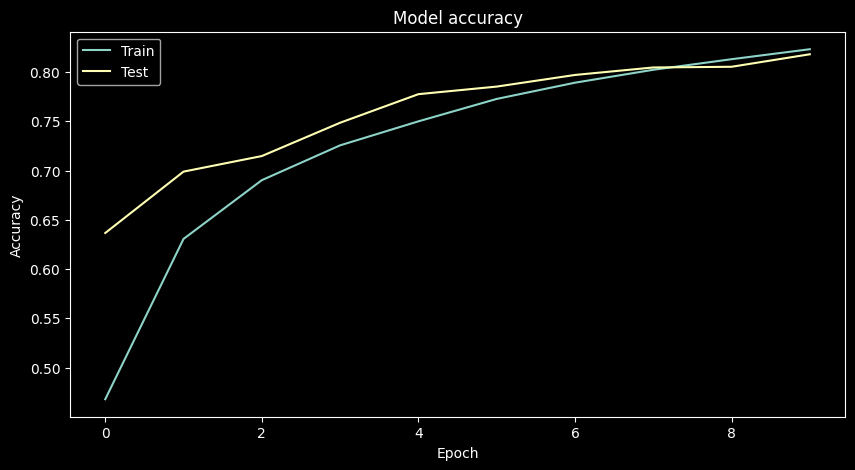

In [35]:
# Plot training & validation accuracy values
plt.style.use(['dark_background'])
fig, ax = plt.subplots(figsize=(10, 5))
plt.plot(history_final.history['accuracy'])
plt.plot(history_final.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

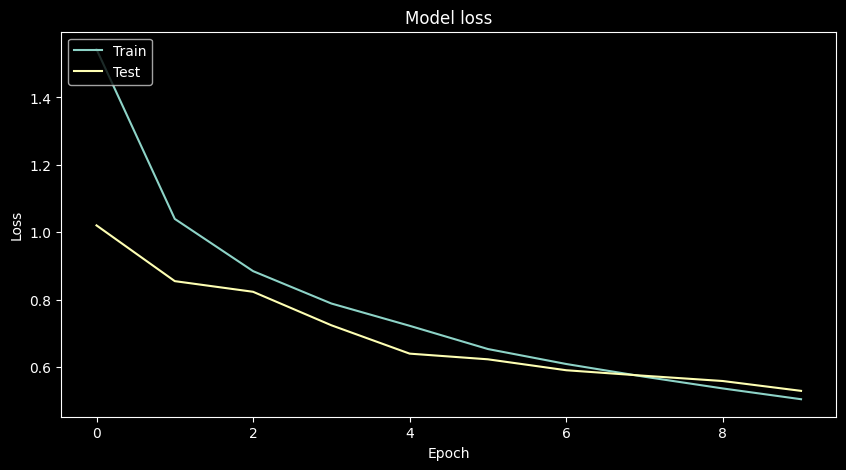

In [36]:
# Plot training & validation loss values
plt.style.use(['dark_background'])
fig, ax = plt.subplots(figsize=(10, 5))
plt.plot(history_final.history['loss'])
plt.plot(history_final.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [37]:
# Вывод истории обучения 
print('=====', 'final model accuracy:', '=====')
print(history_final.history['accuracy'])
print(history_final.history['val_accuracy'])
print('=====', 'final model loss:', '=====')
print(history_final.history['loss'])
print(history_final.history['val_loss'])

===== final model accuracy: =====
[0.46790000796318054, 0.6305999755859375, 0.6902199983596802, 0.7255600094795227, 0.7499200105667114, 0.7726600170135498, 0.789139986038208, 0.8022599816322327, 0.8129799962043762, 0.8231199979782104]
[0.6366000175476074, 0.6988999843597412, 0.7146999835968018, 0.7484999895095825, 0.7774999737739563, 0.7851999998092651, 0.796999990940094, 0.8046000003814697, 0.8052999973297119, 0.8180000185966492]
===== final model loss: =====
[1.5430835485458374, 1.039871335029602, 0.885025143623352, 0.7889907956123352, 0.7228999137878418, 0.6539769172668457, 0.6096212267875671, 0.571808934211731, 0.5371224880218506, 0.5051431655883789]
[1.020658254623413, 0.8553268313407898, 0.8237511515617371, 0.7244504690170288, 0.6403371095657349, 0.6235066056251526, 0.5911045670509338, 0.5746486186981201, 0.5591360926628113, 0.5299682021141052]


# Результаты и выводы

Результаты экспериментов:

In [ ]:
# Вывод истории обучения 
print('=====', 'defolt model AVG accuracy:', '=====')
print(avg(history.history)['accuracy'])
print(avg(history.history)['val_accuracy'])
print('=====', 'defolt model AVG loss:', '=====')
print(avg(history.history)['loss'])
print(avg(history.history)['val_loss'])
print('=+*-'*10)

print('=====', 'l2 model AVG accuracy:', '=====')
print(avg(history_l2.history)['accuracy'])
print(avg(history_l2.history)['val_accuracy'])
print('=====', 'l2 model AVG loss:', '=====')
print(avg(history_l2.history)['loss'])
print(avg(history_l2.history)['val_loss'])
print('=+*-'*10)

print('=====', 'augmentation model AVG accuracy:', '=====')
print(avg(history_aug.history)['accuracy'])
print(avg(history_aug.history)['val_accuracy'])
print('=====', 'augmentation model AVG loss:', '=====')
print(avg(history_aug.history)['loss'])
print(avg(history_aug.history)['val_loss'])
print('=+*-'*10)

print('=====', 'batch_normalize model AVG accuracy:', '=====')
print(avg(history_batch.history)['accuracy'])
print(avg(history_batch.history)['val_accuracy'])
print('=====', 'batch_normalize model AVG loss:', '=====')
print(avg(history_batch.history)['loss'])
print(avg(history_batch.history)['val_loss'])
print('=+*-'*10)

print('=====', 'final model AVG accuracy:', '=====')
print(avg(history_final.history)['accuracy'])
print(avg(history_final.history)['val_accuracy'])
print('=====', 'final model AVG loss:', '=====')
print(avg(history_final.history)['loss'])
print(avg(history_final.history)['val_loss'])


===== defolt model accuracy: =====
[0.46480000019073486, 0.6196799874305725, 0.6782000064849854, 0.7060400247573853, 0.7299200296401978, 0.7462800145149231, 0.7579799890518188, 0.7684800028800964, 0.7792800068855286, 0.78684002161026]
[0.6298999786376953, 0.6967999935150146, 0.7232000231742859, 0.7171000242233276, 0.7328000068664551, 0.7537999749183655, 0.7549999952316284, 0.7587000131607056, 0.7699000239372253, 0.7742000222206116]
===== defolt model loss: =====
[1.4732887744903564, 1.0723850727081299, 0.9216828942298889, 0.8354436159133911, 0.7718756198883057, 0.7259050011634827, 0.6898470520973206, 0.654125988483429, 0.6271124482154846, 0.6019794940948486]
[1.0486303567886353, 0.8607180714607239, 0.7909854054450989, 0.8361409306526184, 0.7786623239517212, 0.7183265089988708, 0.726794958114624, 0.718397855758667, 0.6875150799751282, 0.6649067401885986]
=+*-=+*-=+*-=+*-=+*-=+*-=+*-=+*-=+*-=+*-
===== l2 model accuracy: =====
[0.44359999895095825, 0.5692200064659119, 0.6154000163078308, 

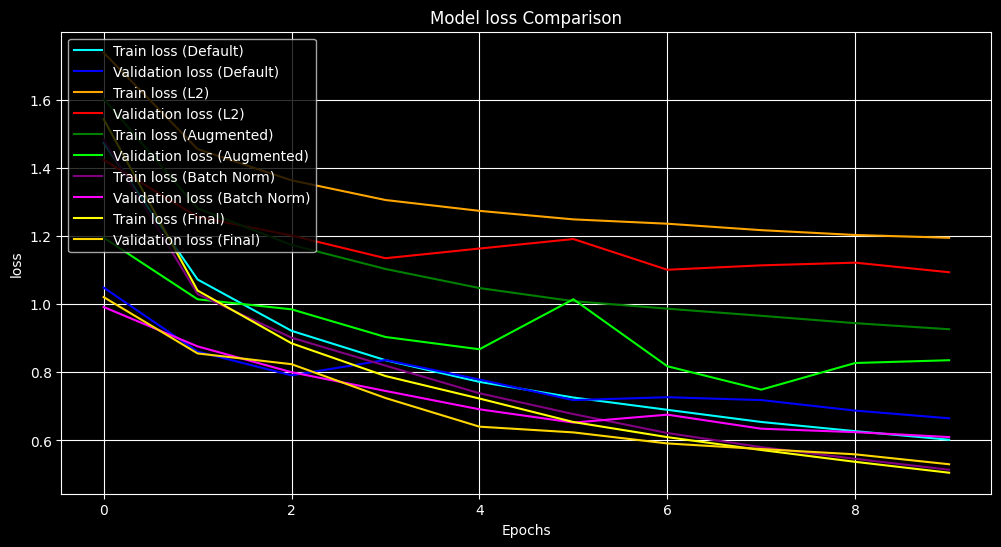

In [ ]:
# Настройка стиля графика
plt.style.use(['dark_background'])
fig, ax = plt.subplots(figsize=(12, 6))

# Плотим точность для каждой модели
#plt.plot(history.history['loss'], label='Train loss (Default)', color='cyan')
plt.plot(history.history['val_loss'], label='Validation loss (Default)', color='blue')

#plt.plot(history_l2.history['loss'], label='Train loss (L2)', color='orange')
plt.plot(history_l2.history['val_loss'], label='Validation loss (L2)', color='red')

#plt.plot(history_aug.history['loss'], label='Train loss (Augmented)', color='green')
plt.plot(history_aug.history['val_loss'], label='Validation loss (Augmented)', color='lime')

#plt.plot(history_batch.history['loss'], label='Train loss (Batch Norm)', color='purple')
plt.plot(history_batch.history['val_loss'], label='Validation loss (Batch Norm)', color='magenta')

#plt.plot(history_final.history['loss'], label='Train loss (Final)', color='yellow')
plt.plot(history_final.history['val_loss'], label='Validation loss (Final)', color='gold')

# Настройка заголовка и меток
plt.title('Model loss Comparison')
plt.ylabel('loss')
plt.xlabel('Epochs')
plt.legend(loc='upper left')
plt.grid(True)

# Показать график
plt.show()

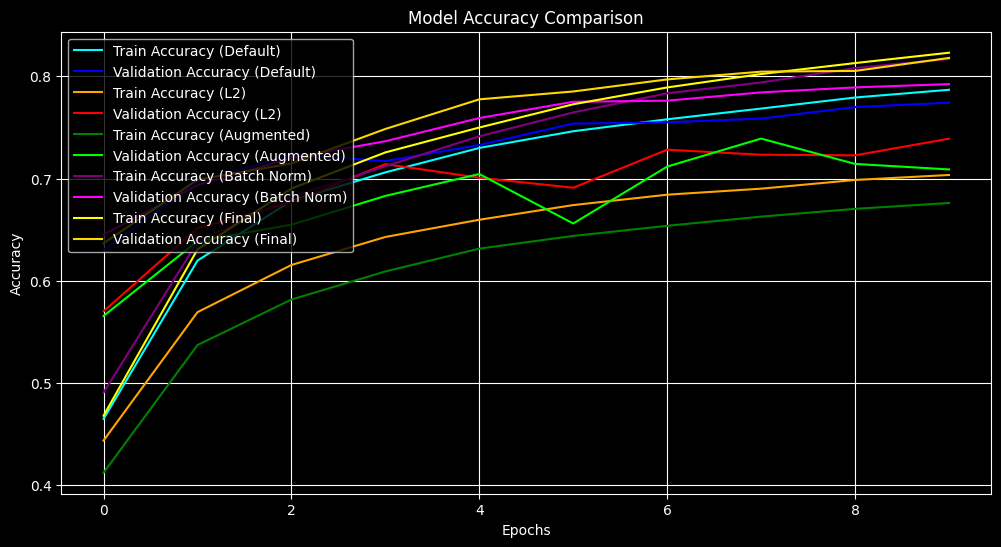

In [ ]:
# Настройка стиля графика
plt.style.use(['dark_background'])
fig, ax = plt.subplots(figsize=(12, 6))

# Плотим точность для каждой модели
#plt.plot(history.history['accuracy'], label='Train Accuracy (Default)', color='cyan')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy (Default)', color='blue')

#plt.plot(history_l2.history['accuracy'], label='Train Accuracy (L2)', color='orange')
plt.plot(history_l2.history['val_accuracy'], label='Validation Accuracy (L2)', color='red')

#plt.plot(history_aug.history['accuracy'], label='Train Accuracy (Augmented)', color='green')
plt.plot(history_aug.history['val_accuracy'], label='Validation Accuracy (Augmented)', color='lime')

#plt.plot(history_batch.history['accuracy'], label='Train Accuracy (Batch Norm)', color='purple')
plt.plot(history_batch.history['val_accuracy'], label='Validation Accuracy (Batch Norm)', color='magenta')

#plt.plot(history_final.history['accuracy'], label='Train Accuracy (Final)', color='yellow')
plt.plot(history_final.history['val_accuracy'], label='Validation Accuracy (Final)', color='gold')

# Настройка заголовка и меток
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(loc='upper left')
plt.grid(True)

# Показать график
plt.show()

Выводы по результатам экспериментов:

** Общая информация о моделях

    1. Модель по умолчанию (Default Model): Базовая модель с использованием сверточных слоев.

    2. Модель с L2-регуляризацией (L2 Model): Модель, в которой применяется L2-регуляризация для борьбы с переобучением.

    3. Модель с аугментацией (Augmentation Model): Модель, использующая аугментацию данных для увеличения объема обучающего набора.

    4. Модель с Batch Normalization (Batch Normalize Model): Модель, в которой применяются слои Batch Normalization для нормализации активаций.
    
    5. Финальная модель (Final Model): Объединение различных техник и улучшений для достижения наилучшей производительности.


** Результаты обучения моделей:


1. Модель по умолчанию (Default Model)

    Точность:

        Обучающая: [0.4648, 0.6197, 0.6782, 0.7060, 0.7299, 0.7463, 0.7580, 0.7685, 0.7793, 0.7868]

        Валидационная: [0.6299, 0.6968, 0.7232, 0.7171, 0.7328, 0.7538, 0.7550, 0.7587, 0.7699, 0.7742]

    Потери:

        Обучающая: [1.4733, 1.0724, 0.9217, 0.8354, 0.7719, 0.7259, 0.6898, 0.6541, 0.6271, 0.6020]

        Валидационная: [1.0486, 0.8607, 0.7910, 0.8361, 0.7787, 0.7183, 0.7268, 0.7184, 0.6875, 0.6649]

Выводы:

    Модель показывает стабильный рост точности на обучающем наборе данных и валидационном наборе данных.
    Потери уменьшаются по мере обучения.



2. Модель с L2-регуляризацией (L2 Model)

    Точность:

        Обучающая: [0.44359999895095825, 0.5692200064659119, 0.6154000163078308, 0.6428200006484985, 0.6596599817276001, 0.674019992351532, 0.6841800212860107, 0.6900799870491028, 0.6985999941825867, 0.7034800052642822]

        Валидационная: [0.5701000094413757, 0.6514000296592712, 0.6765000224113464, 0.7141000032424927, 0.7008000016212463, 0.6909999847412109, 0.7282000184059143, 0.7232999801635742, 0.7226999998092651, 0.7390000224113464]

    Потери:

        Обучающая: [1.7381136417388916, 1.4551193714141846, 1.3635004758834839, 1.3057215213775635, 1.2738982439041138, 1.248865008354187, 1.2361291646957397, 1.2172220945358276, 1.2030534744262695, 1.1948720216751099]

        Валидационная: [1.4233499765396118, 1.2561962604522705, 1.2015634775161743, 1.1348271369934082, 1.163238525390625, 1.1911519765853882, 1.100967526435852, 1.1139088869094849, 1.1218277215957642, 1.0936250686645508]

Выводы:

    Точность моделей с L2-регуляризацией значительно ниже по сравнению с моделью по умолчанию.
    Это может указывать на слишком сильное влияние регуляризации или недостаточную сложность модели для захвата паттернов в данных.



3. Модель с аугментацией (Augmentation Model)

    Точность:

        Обучающая: [0.4120999872684479, 0.5370399951934814, 0.5815799832344055, 0.6090599894523621, 0.6314200162887573, 0.6438199877738953, 0.6537399888038635, 0.6627200245857239, 0.6703199744224548, 0.6760600209236145]

        Валидационная: [0.565500020980835, 0.638700008392334, 0.6547999978065491, 0.6830000281333923, 0.7044000029563904, 0.656000018119812, 0.7117000222206116, 0.7390999794006348, 0.7142999768257141, 0.708899974822998]

    Потери:

        Обучающая: [1.603161096572876, 1.2812167406082153, 1.1739368438720703, 1.1032664775848389, 1.0472904443740845, 1.0087164640426636, 0.9867203831672668, 0.965798020362854, 0.9442028403282166, 0.9263547658920288]

        Валидационная: [1.1951885223388672, 1.0142842531204224, 0.9847710728645325, 0.903616189956665, 0.8675587773323059, 1.0143519639968872, 0.8177534937858582, 0.7490099668502808, 0.8272485136985779, 0.8353785872459412]

Выводы:

    Аугментация данных улучшает результаты по сравнению с моделью с L2-регуляризацией.
    Однако точность все еще ниже по сравнению с моделью по умолчанию.



4. Модель с Batch Normalization (Batch Normalize Model)

    Точность:

        Обучающая: [0.49052000045776367, 0.6379600167274475, 0.6821399927139282, 0.7120800018310547, 0.7413399815559387, 0.7646999955177307, 0.7834200263023376, 0.7940000295639038, 0.808139979839325, 0.817080020904541]

        Валидационная: [0.6450999975204468, 0.6935999989509583, 0.7200000286102295, 0.7365000247955322, 0.7591999769210815, 0.7750999927520752, 0.776199996471405, 0.7843000292778015, 0.7892000079154968, 0.7924000024795532]

    Потери:

        Обучающая: [1.4834609031677246, 1.029551386833191, 0.9015776515007019, 0.8194211721420288, 0.7384814620018005, 0.6773121356964111, 0.621784508228302, 0.5802688002586365, 0.5459288954734802, 0.5138464570045471]

        Валидационная: [0.9916340708732605, 0.876015841960907, 0.8002157211303711, 0.7452287077903748, 0.6913320422172546, 0.6523609757423401, 0.6755823493003845, 0.6343644857406616, 0.6242715120315552, 0.6097897887229919]

Выводы:

    Модель с Batch Normalization показывает значительное улучшение точности и снижение потерь по сравнению с предыдущими моделями.
    Batch Normalization помогает улучшить обучение и ускорить его.



5. Финальная модель (Final Model)

    Точность:

        Обучающая: [0.46790000796318054, 0.6305999755859375, 0.6902199983596802, 0.7255600094795227, 0.7499200105667114, 0.7726600170135498, 0.789139986038208, 0.8022599816322327, 0.8129799962043762, 0.8231199979782104]

        Валидационная: [0.6366000175476074, 0.6988999843597412, 0.7146999835968018, 0.7484999895095825, 0.7774999737739563, 0.7851999998092651, 0.796999990940094, 0.8046000003814697, 0.8052999973297119, 0.8180000185966492]

    Потери:
    
        Обучающая: [1.5430835485458374, 1.039871335029602, 0.885025143623352, 0.7889907956123352, 0.7228999137878418, 0.6539769172668457, 0.6096212267875671, 0.571808934211731, 0.5371224880218506, 0.5051431655883789]

        Валидационная: [1.020658254623413, 0.8553268313407898, 0.8237511515617371, 0.7244504690170288, 0.6403371095657349, 0.6235066056251526, 0.5911045670509338, 0.5746486186981201, 0.5591360926628113, 0.5299682021141052]

Выводы:

    Финальная модель демонстрирует хорошие результаты и улучшение точности и снижения потерь по сравнению с другими моделями.


Итог:

    Оптимизация регуляризации:

        Необходима настройка коэффицента L2-регуляризации для нахождения оптимального значения (первичный эксперимент проводился с коэффицентом - 0.01, изменение коэффицента на 0.001 улучшило результат).

    Аугментация данных:

        Хорошо себя показала аугментация данных для увеличения объема обучающего набора и улучшения обобщающей способности модели. Однако стоит отметить два важных момента: вопервых аугментация ощутимо увеличила время обучения модели (процентов на 30), во вторых применяемая версия tensorflow==2.1 не поддерживает возможность добавлять аугментацию непосредственно в слои нейросети.

    Использование Batch Normalization:
    
        Применение Batch Normalization после каждого сверточного слоя улучшило стабильность и скорость обучения модели.
    


Резюме:

    Добавление дополнительных слоев в архитектуру нейросети улчшает качество модели.

    Применение l2-регуляризации требует тщательной настройки коэффицента.

    Применение аугментации рекомендуется во всех случаях, когда вычислительное время не критично.

    Применение Batch Normalization, на мой взгляд оправдано всегда.